In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier


In [7]:
# Load the uploaded file to analyze its content

heart_data = pd.read_csv('/content/sample_data/Combined clinics.csv')

# Display the first few rows and data information for context
heart_data_info = heart_data.info()
heart_data_preview = heart_data.head()

heart_data_info, heart_data_preview


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       920 non-null    int64 
 1   sex       920 non-null    int64 
 2   cp        920 non-null    int64 
 3   trestbps  920 non-null    object
 4   chol      920 non-null    object
 5   fbs       920 non-null    object
 6   restecg   920 non-null    object
 7   thalach   920 non-null    object
 8   exang     920 non-null    object
 9   oldpeak   920 non-null    object
 10  slope     920 non-null    object
 11  ca        920 non-null    object
 12  thal      920 non-null    object
 13  num       920 non-null    int64 
dtypes: int64(4), object(10)
memory usage: 100.8+ KB


(None,
    age  sex  cp trestbps chol fbs restecg thalach exang oldpeak slope ca thal  \
 0   32    1   1       95    0   ?       0     127     0     0.7     1  ?    ?   
 1   34    1   4      115    0   ?       ?     154     0     0.2     1  ?    ?   
 2   35    1   4        ?    0   ?       0     130     1       ?     ?  ?    7   
 3   36    1   4      110    0   ?       0     125     1       1     2  ?    6   
 4   38    0   4      105    0   ?       0     166     0     2.8     1  ?    ?   
 
    num  
 0    1  
 1    1  
 2    3  
 3    1  
 4    2  )

In [8]:
# Replace remaining non-numeric placeholders ('?') with NaN in the correct DataFrame (heart_data)
heart_data.replace('?', np.nan, inplace=True)

# Reapply numeric conversion to ensure all columns are correctly typed
for col in heart_data.columns:
    heart_data[col] = pd.to_numeric(heart_data[col], errors='coerce')

# Perform iterative imputation
iterative_imputer = IterativeImputer(random_state=42, max_iter=10)
heart_data_imputed = pd.DataFrame(
    iterative_imputer.fit_transform(heart_data),
    columns=heart_data.columns
)

# Validate the results
imputed_heart_data_info = {
    "Missing Values After Fixing": heart_data_imputed.isnull().sum().to_dict(),
    "Sample Imputed Data": heart_data_imputed.head()
}

imputed_heart_data_info


{'Missing Values After Fixing': {'age': 0,
  'sex': 0,
  'cp': 0,
  'trestbps': 0,
  'chol': 0,
  'fbs': 0,
  'restecg': 0,
  'thalach': 0,
  'exang': 0,
  'oldpeak': 0,
  'slope': 0,
  'ca': 0,
  'thal': 0,
  'num': 0},
 'Sample Imputed Data':     age  sex   cp    trestbps  chol       fbs   restecg  thalach  exang  \
 0  32.0  1.0  1.0   95.000000   0.0 -0.160722  0.000000    127.0    0.0   
 1  34.0  1.0  4.0  115.000000   0.0 -0.071003  0.094264    154.0    0.0   
 2  35.0  1.0  4.0  123.583296   0.0  0.010893  0.000000    130.0    1.0   
 3  36.0  1.0  4.0  110.000000   0.0 -0.072775  0.000000    125.0    1.0   
 4  38.0  0.0  4.0  105.000000   0.0 -0.142828  0.000000    166.0    0.0   
 
     oldpeak     slope        ca      thal  num  
 0  0.700000  1.000000  0.080730  4.038078  1.0  
 1  0.200000  1.000000  0.138622  4.732953  1.0  
 2  1.401182  2.007538  0.632076  7.000000  3.0  
 3  1.000000  2.000000  0.034868  6.000000  1.0  
 4  2.800000  1.000000  0.747394  4.260171  2.0 

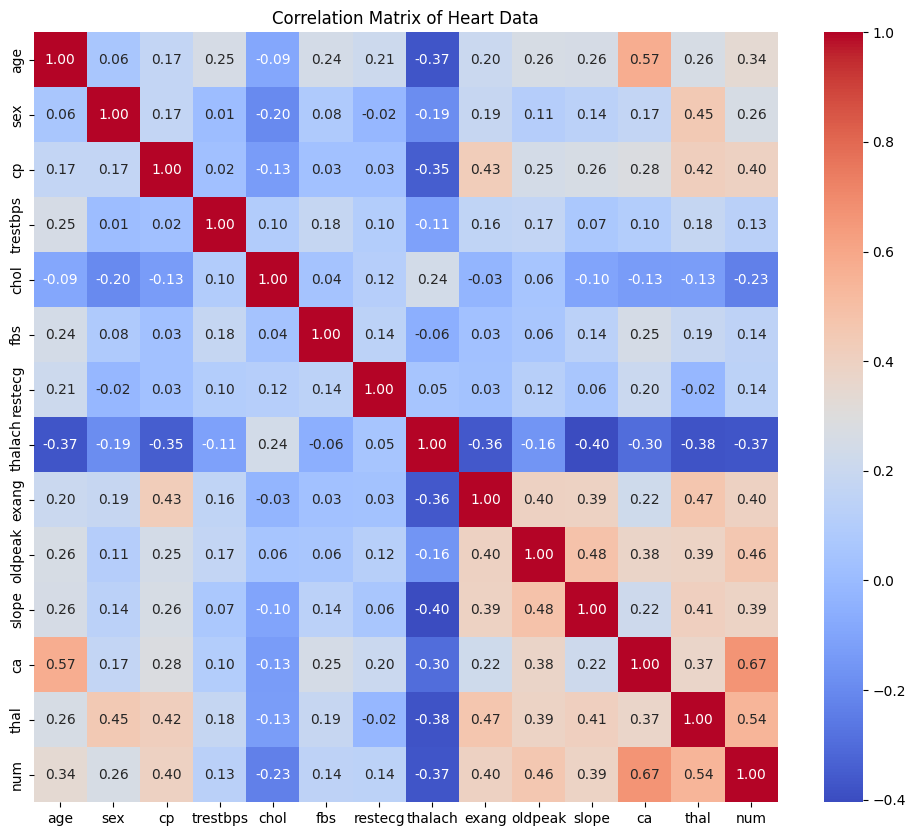

In [9]:
# Compute the correlation matrix
correlation_matrix = heart_data_imputed.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Heart Data")
plt.show()


In [10]:
# Define a correlation threshold
correlation_threshold = 0.9

# Create a correlation matrix
correlation_matrix = heart_data_imputed.corr()

# Select upper triangle of the correlation matrix to avoid redundancy
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

# Find index of features with correlation greater than the threshold
highly_correlated_cols = [
    column for column in upper_triangle.columns
    if any(upper_triangle[column] > correlation_threshold)
]

# Drop highly correlated columns
heart_data_reduced = heart_data_imputed.drop(columns=highly_correlated_cols)

# Display results
print(f"Columns removed: {highly_correlated_cols}")
print(f"Remaining columns: {heart_data_reduced.columns.tolist()}")


Columns removed: []
Remaining columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']


In [12]:
# Identify categorical columns (assuming non-numeric columns are categorical)
categorical_columns = heart_data.select_dtypes(include=['object']).columns.tolist()

# Perform one-hot encoding on the identified categorical columns
heart_data_encoded = pd.get_dummies(heart_data_imputed, columns=categorical_columns, drop_first=True)

# Display the transformed dataset
print("Dataset Shape After Encoding:", heart_data_encoded.shape)
print("Sample Encoded Data:")
print(heart_data_encoded.head())


Dataset Shape After Encoding: (920, 14)
Sample Encoded Data:
    age  sex   cp    trestbps  chol       fbs   restecg  thalach  exang  \
0  32.0  1.0  1.0   95.000000   0.0 -0.160722  0.000000    127.0    0.0   
1  34.0  1.0  4.0  115.000000   0.0 -0.071003  0.094264    154.0    0.0   
2  35.0  1.0  4.0  123.583296   0.0  0.010893  0.000000    130.0    1.0   
3  36.0  1.0  4.0  110.000000   0.0 -0.072775  0.000000    125.0    1.0   
4  38.0  0.0  4.0  105.000000   0.0 -0.142828  0.000000    166.0    0.0   

    oldpeak     slope        ca      thal  num  
0  0.700000  1.000000  0.080730  4.038078  1.0  
1  0.200000  1.000000  0.138622  4.732953  1.0  
2  1.401182  2.007538  0.632076  7.000000  3.0  
3  1.000000  2.000000  0.034868  6.000000  1.0  
4  2.800000  1.000000  0.747394  4.260171  2.0  


In [13]:
from sklearn.preprocessing import StandardScaler
import numpy as np


In [14]:
# Identify numerical columns for standardization
numerical_columns = heart_data_encoded.select_dtypes(include=[np.number]).columns.tolist()

# Initialize the scaler
scaler = StandardScaler()

# Standardize the numerical columns
heart_data_standardized = heart_data_encoded.copy()
heart_data_standardized[numerical_columns] = scaler.fit_transform(heart_data_standardized[numerical_columns])

# Display the transformed dataset
print("Dataset Shape After Standardization:", heart_data_standardized.shape)
print("Sample Standardized Data:")
print(heart_data_standardized.head())


Dataset Shape After Standardization: (920, 14)
Sample Standardized Data:
        age       sex        cp  trestbps      chol       fbs   restecg  \
0 -2.283638  0.516931 -2.418152 -2.020055 -1.825386 -0.907148 -0.750726   
1 -2.071314  0.516931  0.806051 -0.939543 -1.825386 -0.654846 -0.633584   
2 -1.965152  0.516931  0.806051 -0.475826 -1.825386 -0.424542 -0.750726   
3 -1.858990  0.516931  0.806051 -1.209671 -1.825386 -0.659828 -0.750726   
4 -1.646666 -1.934494  0.806051 -1.479799 -1.825386 -0.856828 -0.750726   

    thalach     exang   oldpeak     slope        ca      thal       num  
0 -0.403117 -0.825439 -0.180510 -1.306753 -0.768338 -0.713528  0.003807  
1  0.663274 -0.825439 -0.649935 -1.306753 -0.685546 -0.261011  0.003807  
2 -0.284629  1.272157  0.477795  0.572061  0.020149  1.215336  1.755010  
3 -0.482109  1.272157  0.101145  0.558005 -0.833926  0.564116  0.003807  
4  1.137226 -0.825439  1.791076 -1.306753  0.185068 -0.568897  0.879408  


In [15]:

# Assuming the target variable is the last column
target_column = 'num'
X = heart_data_standardized.drop(columns=[target_column])
y = heart_data_standardized[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the regression model
regressor = LinearRegression()

# Train the regression model
regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

{
    "Mean Squared Error": mse,
    "R2 Score": r2,
    "Coefficients": regressor.coef_,
    "Intercept": regressor.intercept_
}



{'Mean Squared Error': 0.5036768701707259,
 'R2 Score': 0.5540083769416627,
 'Coefficients': array([-0.17305662,  0.02512671,  0.08907236,  0.06499067, -0.14662948,
        -0.02896689,  0.07261706, -0.04730845,  0.0757566 ,  0.09395171,
         0.08667548,  0.57305648,  0.14045401]),
 'Intercept': -0.015676763249120224}

In [16]:
# Convert target variable to categorical for classification
y_classification = (y > y.median()).astype(int)  # Example: Binary classification based on median split

# Split the data for classification
X_train, X_test, y_train, y_test = train_test_split(X, y_classification, test_size=0.2, random_state=42)

# Initialize a classification model (e.g., Random Forest)
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Make predictions
y_pred_class = classifier.predict(X_test)

# Classification metrics
conf_matrix = confusion_matrix(y_test, y_pred_class)
class_report = classification_report(y_test, y_pred_class)

{
    "Confusion Matrix": conf_matrix,
    "Classification Report": class_report
}



{'Confusion Matrix': array([[124,   6],
        [ 14,  40]]),
 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.90      0.95      0.93       130\n           1       0.87      0.74      0.80        54\n\n    accuracy                           0.89       184\n   macro avg       0.88      0.85      0.86       184\nweighted avg       0.89      0.89      0.89       184\n'}

In [17]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)

# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logistic))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       130
           1       0.79      0.70      0.75        54

    accuracy                           0.86       184
   macro avg       0.84      0.81      0.82       184
weighted avg       0.86      0.86      0.86       184



In [18]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree Classifier
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)
y_pred_tree = decision_tree.predict(X_test)

# Evaluation
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_tree))


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       130
           1       0.78      0.72      0.75        54

    accuracy                           0.86       184
   macro avg       0.83      0.82      0.83       184
weighted avg       0.86      0.86      0.86       184



In [19]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classifier
random_forest = RandomForestClassifier(random_state=42, n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)

# Evaluation
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       130
           1       0.87      0.74      0.80        54

    accuracy                           0.89       184
   macro avg       0.88      0.85      0.86       184
weighted avg       0.89      0.89      0.89       184



In [20]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# Evaluation
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       130
           1       0.84      0.67      0.74        54

    accuracy                           0.86       184
   macro avg       0.85      0.81      0.83       184
weighted avg       0.86      0.86      0.86       184



In [21]:
from sklearn.linear_model import LinearRegression

# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred_lr = linear_reg.predict(X_test)

# Evaluation
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression MSE: {mse_lr:.4f}, R2: {r2_lr:.4f}")


Linear Regression MSE: 0.1223, R2: 0.4100


In [22]:
from sklearn.svm import SVC

# Support Vector Classifier
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Evaluation
print("Support Vector Machines Classification Report:")
print(classification_report(y_test, y_pred_svm))


Support Vector Machines Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       130
           1       0.83      0.72      0.77        54

    accuracy                           0.88       184
   macro avg       0.86      0.83      0.84       184
weighted avg       0.87      0.88      0.87       184



In [23]:
from sklearn.tree import DecisionTreeRegressor

# Decision Tree Regressor
tree_regressor = DecisionTreeRegressor(random_state=42)
tree_regressor.fit(X_train, y_train)
y_pred_tree_reg = tree_regressor.predict(X_test)

# Evaluation
mse_tree = mean_squared_error(y_test, y_pred_tree_reg)
r2_tree = r2_score(y_test, y_pred_tree_reg)
print(f"Decision Tree Regressor MSE: {mse_tree:.4f}, R2: {r2_tree:.4f}")


Decision Tree Regressor MSE: 0.1413, R2: 0.3185


In [24]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest Regressor
forest_regressor = RandomForestRegressor(random_state=42, n_estimators=100)
forest_regressor.fit(X_train, y_train)
y_pred_forest_reg = forest_regressor.predict(X_test)

# Evaluation
mse_forest = mean_squared_error(y_test, y_pred_forest_reg)
r2_forest = r2_score(y_test, y_pred_forest_reg)
print(f"Random Forest Regressor MSE: {mse_forest:.4f}, R2: {r2_forest:.4f}")


Random Forest Regressor MSE: 0.0805, R2: 0.6115


In [25]:
from sklearn.ensemble import GradientBoostingRegressor

# Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(random_state=42)
gb_regressor.fit(X_train, y_train)
y_pred_gb_reg = gb_regressor.predict(X_test)

# Evaluation
mse_gb = mean_squared_error(y_test, y_pred_gb_reg)
r2_gb = r2_score(y_test, y_pred_gb_reg)
print(f"Gradient Boosting Regressor MSE: {mse_gb:.4f}, R2: {r2_gb:.4f}")


Gradient Boosting Regressor MSE: 0.0901, R2: 0.5655


In [26]:
from sklearn.neighbors import KNeighborsClassifier

# KNN Classifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

# Evaluation
print("K-Nearest Neighbors Classification Report:")
print(classification_report(y_test, y_pred_knn))


K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       130
           1       0.73      0.67      0.70        54

    accuracy                           0.83       184
   macro avg       0.80      0.78      0.79       184
weighted avg       0.83      0.83      0.83       184



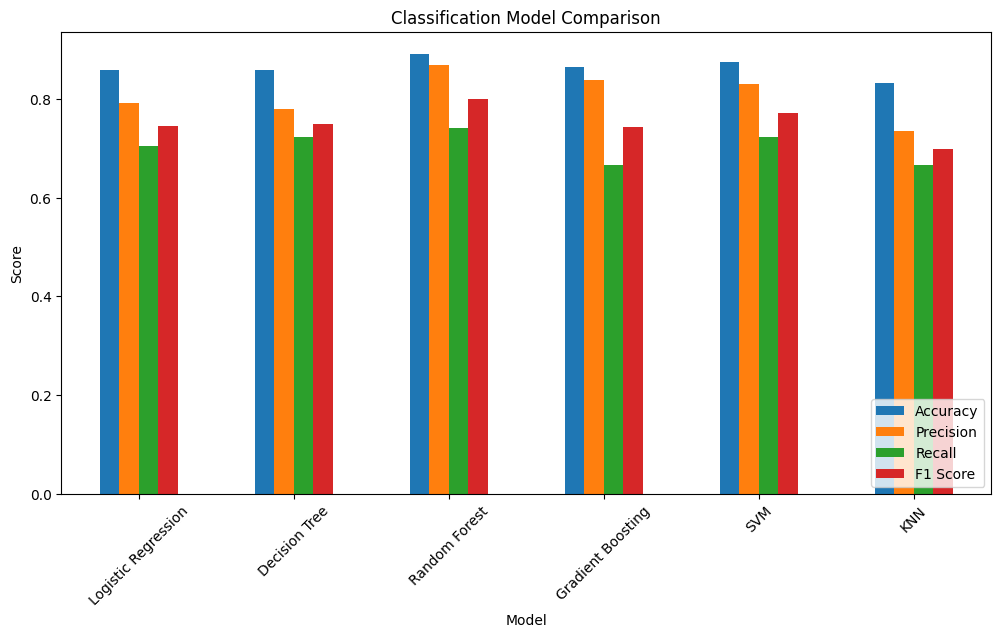

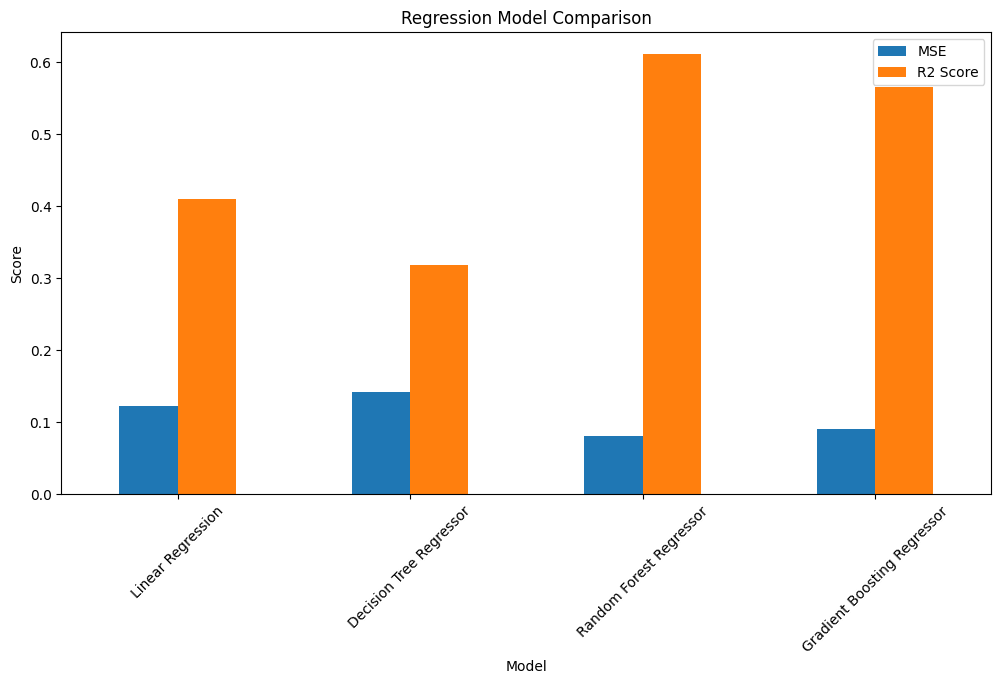

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Initialize classification models
classification_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(kernel='linear', random_state=42),
    "KNN": KNeighborsClassifier()
}

# Initialize regression models
regression_models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42)
}

# Evaluate classification models
classification_results = []
for name, model in classification_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    classification_results.append({"Model": name, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1})

# Evaluate regression models
regression_results = []
for name, model in regression_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    regression_results.append({"Model": name, "MSE": mse, "R2 Score": r2})

# Visualization
import pandas as pd
import matplotlib.pyplot as plt

# Convert results to DataFrame
classification_df = pd.DataFrame(classification_results)
regression_df = pd.DataFrame(regression_results)

# Plot Classification Results
classification_df.set_index("Model").plot(kind="bar", figsize=(12, 6), title="Classification Model Comparison", ylabel="Score")
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()

# Plot Regression Results
regression_df.set_index("Model").plot(kind="bar", figsize=(12, 6), title="Regression Model Comparison", ylabel="Score")
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()


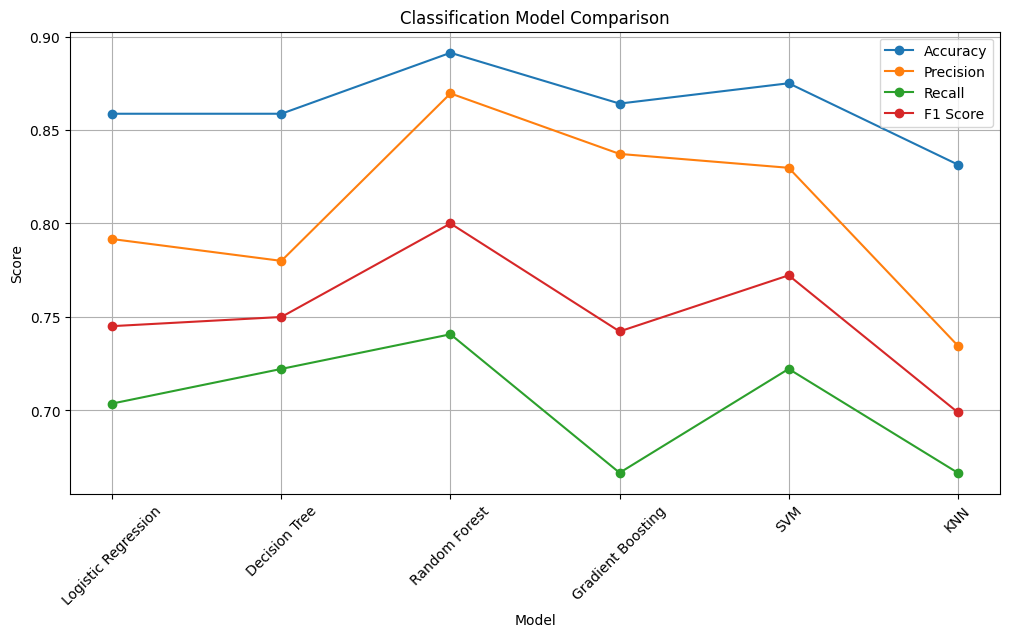

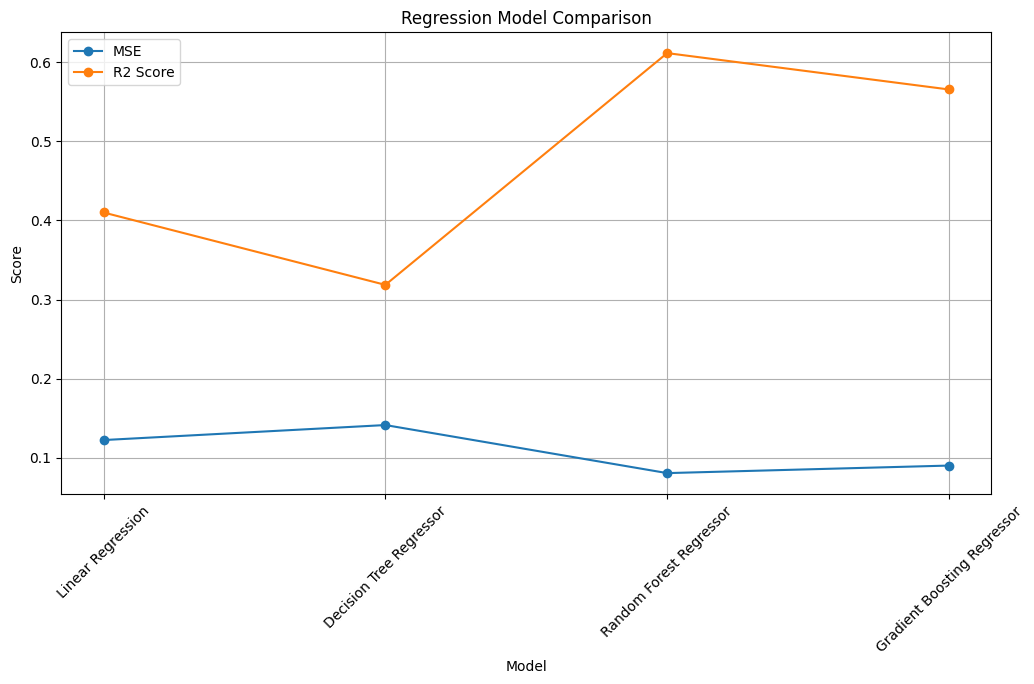

In [28]:
# Line plot for classification models
plt.figure(figsize=(12, 6))
for metric in ["Accuracy", "Precision", "Recall", "F1 Score"]:
    plt.plot(classification_df["Model"], classification_df[metric], marker="o", label=metric)
plt.title("Classification Model Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

# Line plot for regression models
plt.figure(figsize=(12, 6))
for metric in ["MSE", "R2 Score"]:
    plt.plot(regression_df["Model"], regression_df[metric], marker="o", label=metric)
plt.title("Regression Model Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()


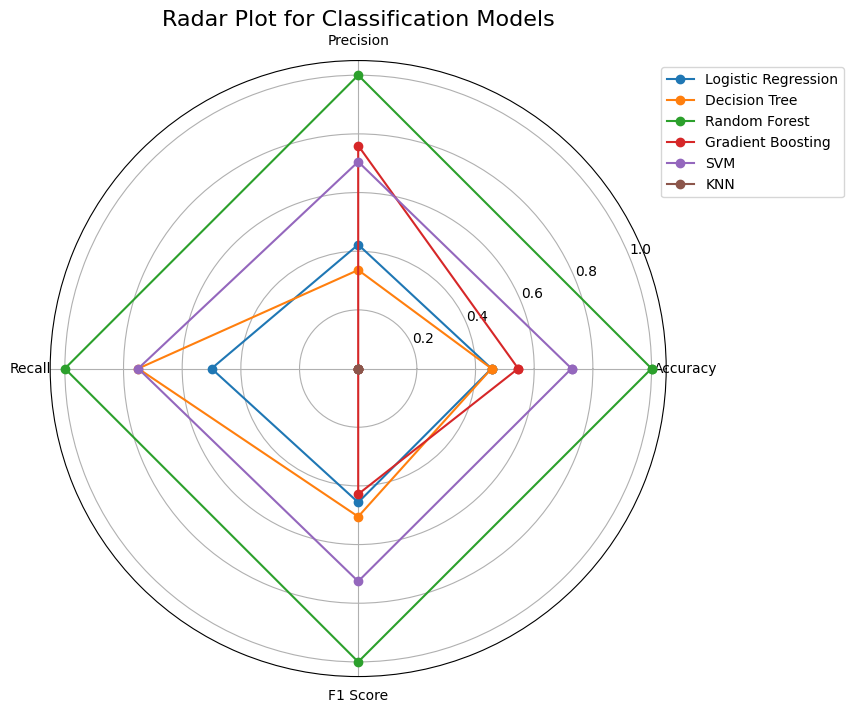

In [29]:
from math import pi

# Normalize classification metrics to [0, 1] for radar plot
classification_normalized = classification_df.drop(columns=["Model"]).copy()
classification_normalized = (classification_normalized - classification_normalized.min()) / (
    classification_normalized.max() - classification_normalized.min()
)
classification_normalized["Model"] = classification_df["Model"]

# Radar plot for classification models
categories = classification_df.columns[1:].tolist()
num_vars = len(categories)

angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # Repeat the first angle to close the radar chart

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

for i, row in classification_normalized.iterrows():
    values = row[categories].tolist()
    values += values[:1]  # Repeat the first value to close the radar chart
    ax.plot(angles, values, label=row["Model"], marker="o")

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.title("Radar Plot for Classification Models", size=16)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.show()


In [30]:
# Set up the plotting style
sns.set(style="whitegrid")

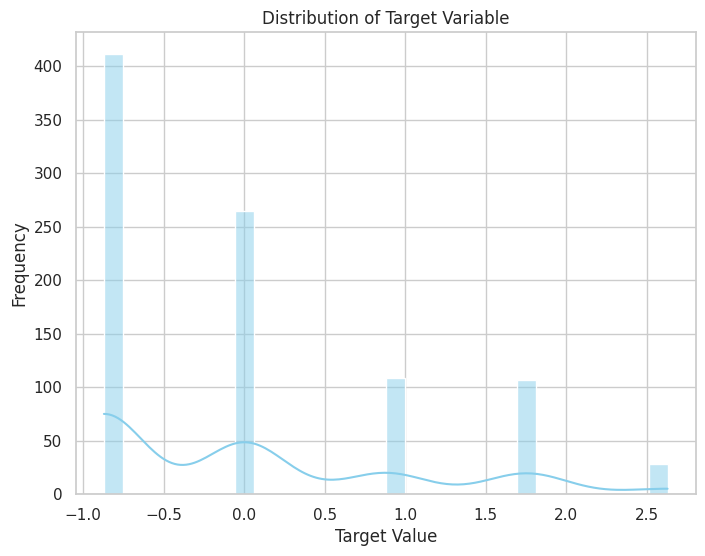

In [31]:
# 1. Distribution plot for the target variable
plt.figure(figsize=(8, 6))
sns.histplot(y, kde=True, bins=30, color='skyblue')
plt.title("Distribution of Target Variable")
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.show()

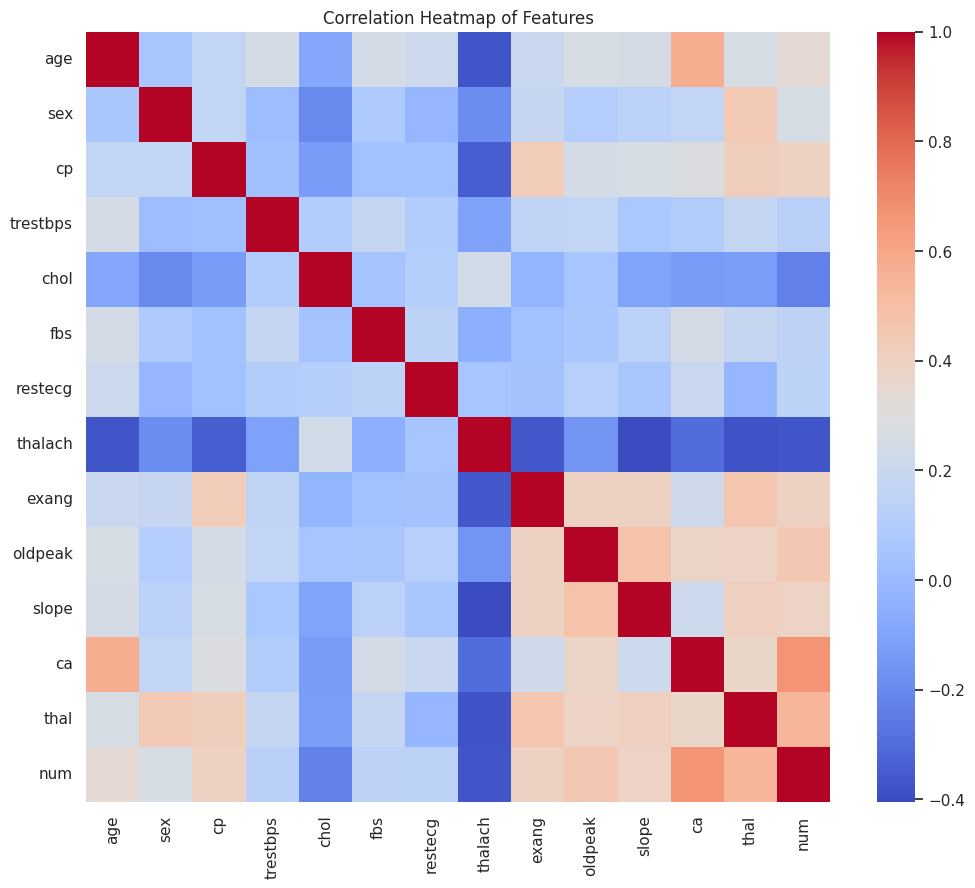

In [32]:
# 2. Correlation heatmap for all features
plt.figure(figsize=(12, 10))
sns.heatmap(heart_data_standardized.corr(), annot=False, cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Features")
plt.show()

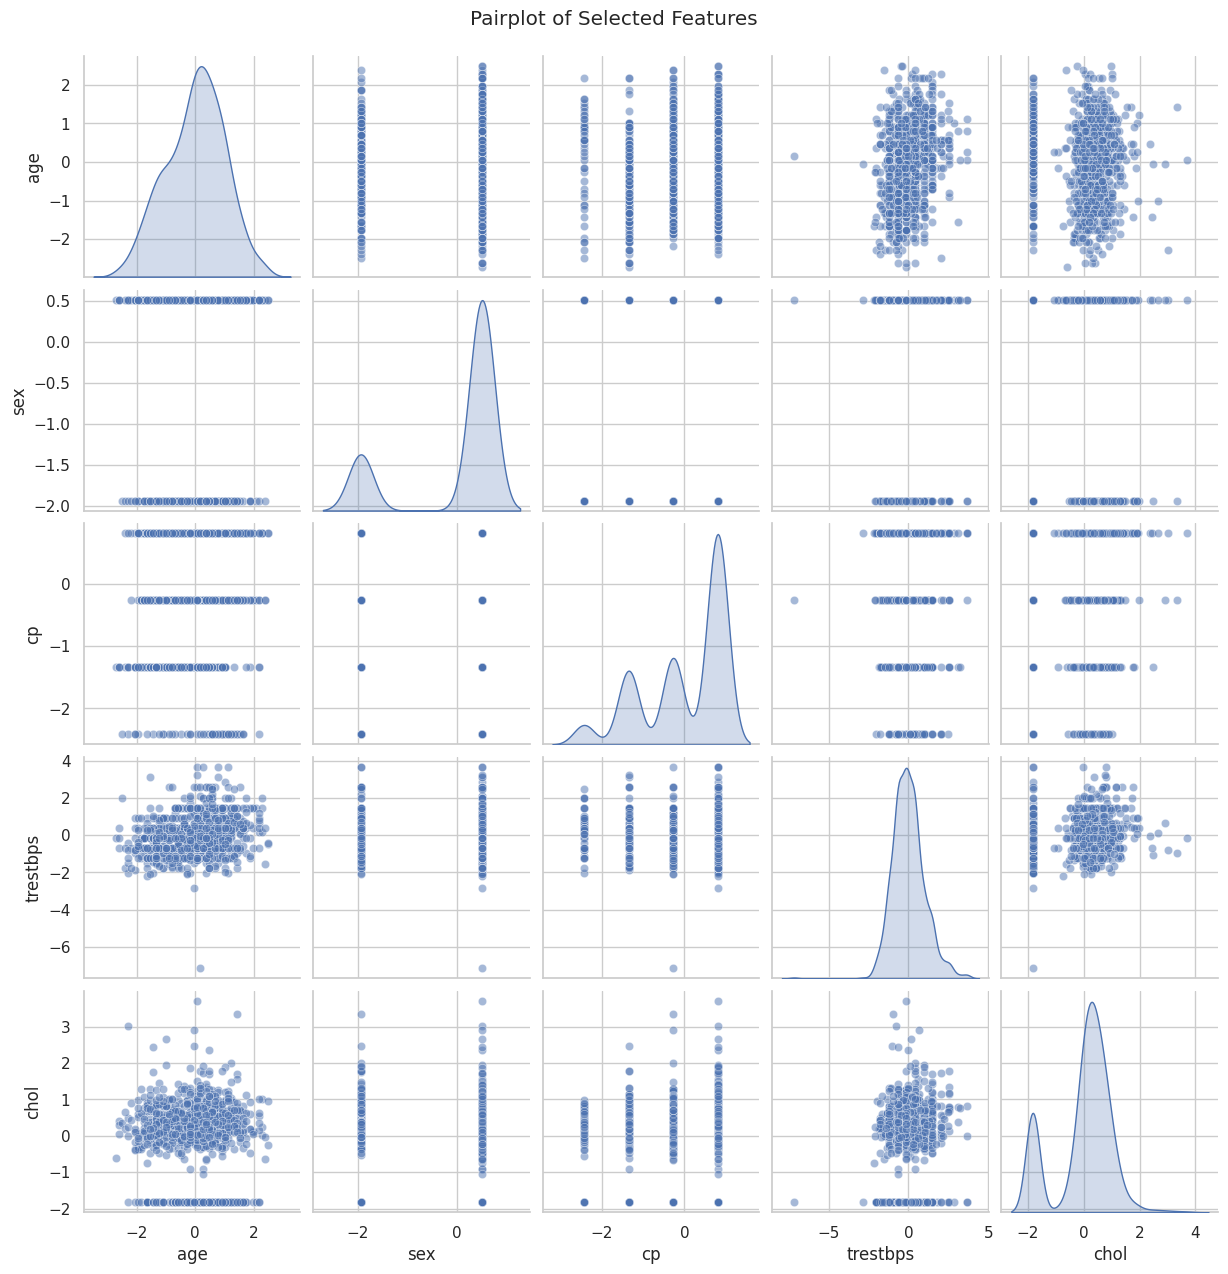

In [33]:
# 3. Pairplot for a subset of features to observe relationships
selected_features = X.columns[:5]  # Select the first 5 features for simplicity
sns.pairplot(heart_data_standardized[selected_features], diag_kind='kde', plot_kws={"alpha": 0.5})
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()

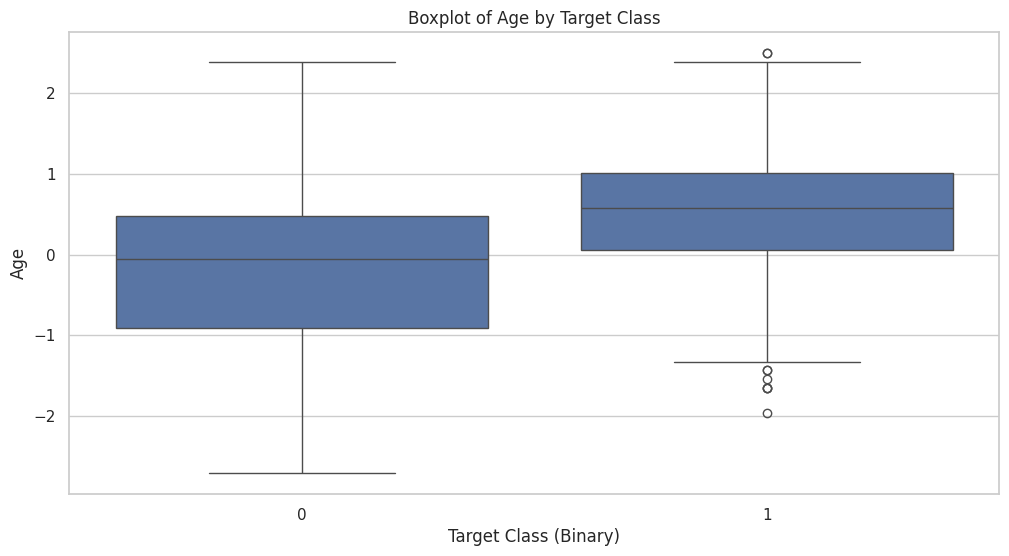

In [34]:
# 4. Box plot for feature distributions by the target class
plt.figure(figsize=(12, 6))
sns.boxplot(data=heart_data_standardized, x=y_classification, y='age')
plt.title("Boxplot of Age by Target Class")
plt.xlabel("Target Class (Binary)")
plt.ylabel("Age")
plt.show()

In [35]:
# 5. Count plot for a categorical feature (if any exist)
if categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=categorical_columns[0], data=heart_data)
    plt.title(f"Count Plot for {categorical_columns[0]}")
    plt.show()

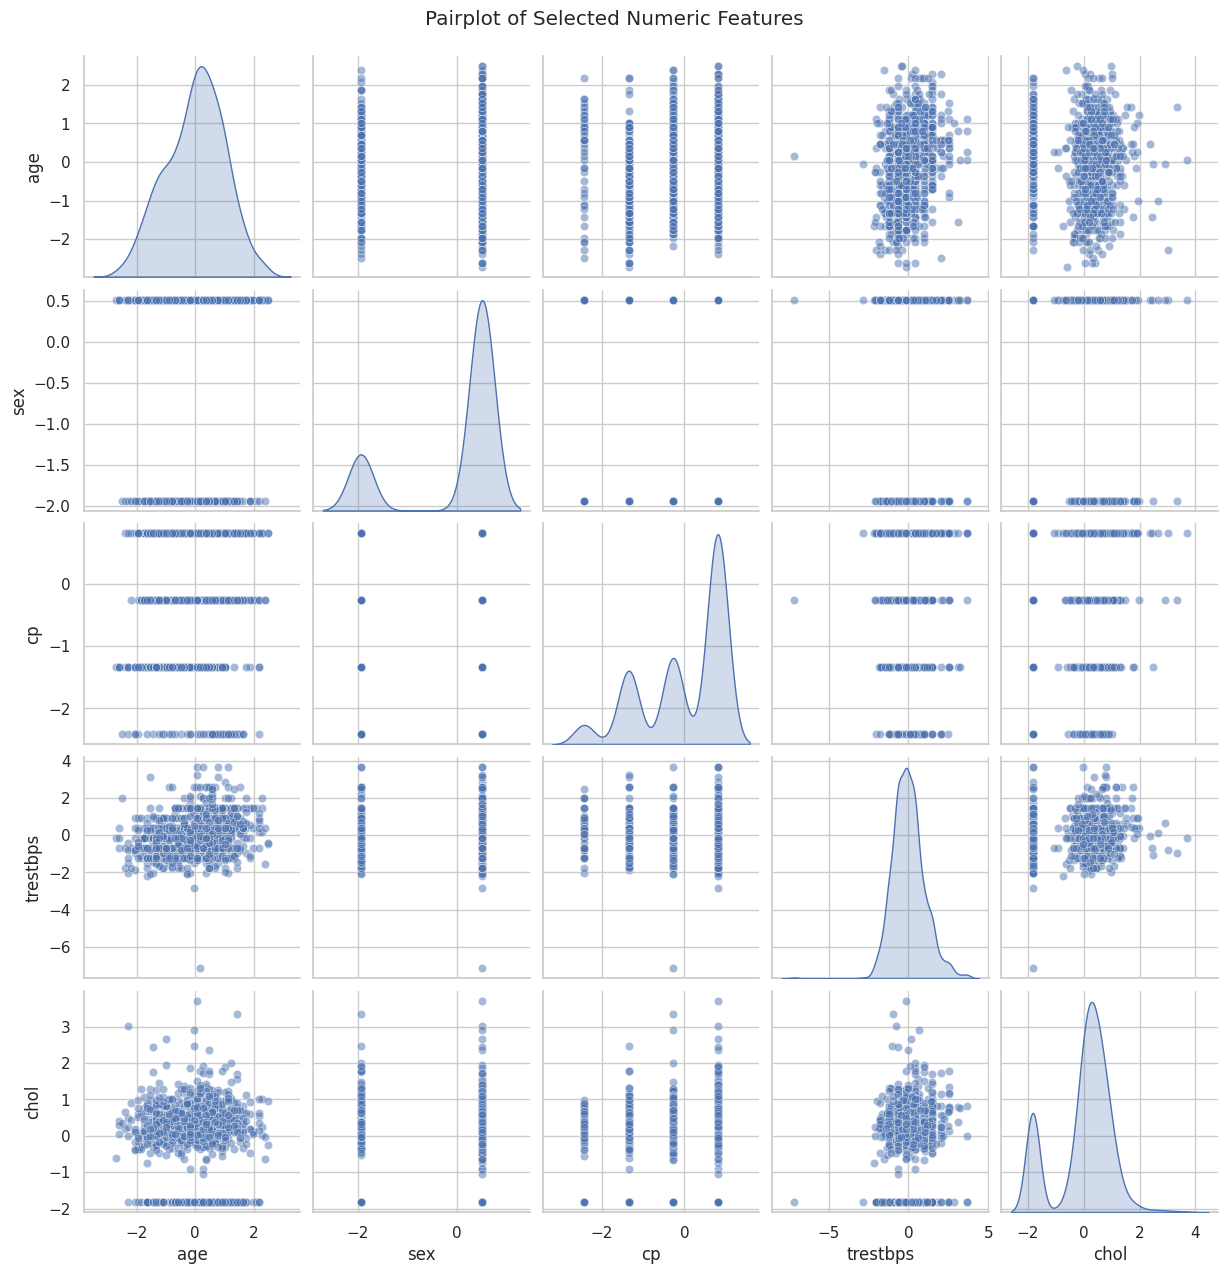

In [36]:
# Select numeric columns for pairplot
numeric_features = X.select_dtypes(include=[np.number]).columns[:5]  # Select first 5 numeric features

# Corrected Pairplot for numeric features
sns.pairplot(heart_data_standardized[numeric_features], diag_kind='kde', plot_kws={"alpha": 0.5})
plt.suptitle("Pairplot of Selected Numeric Features", y=1.02)
plt.show()


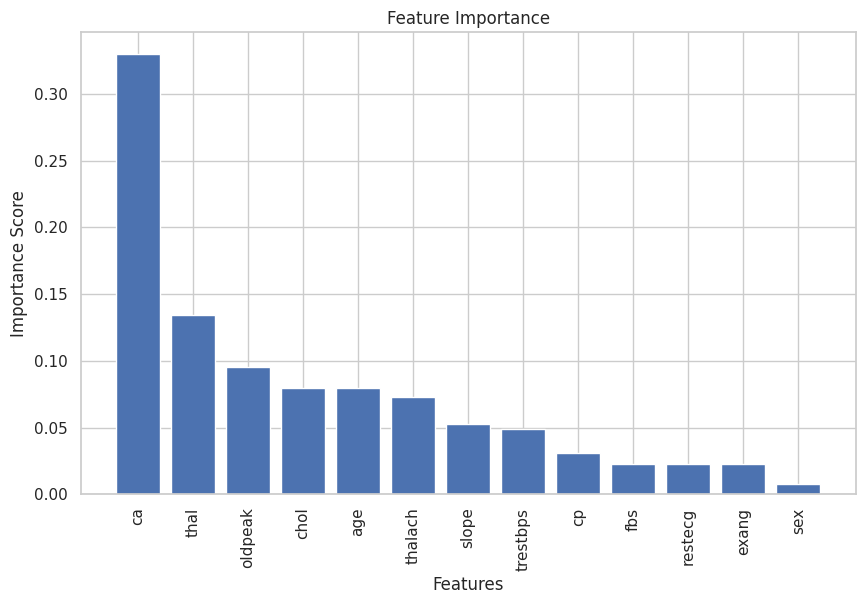

In [37]:
# Feature importance from the RandomForestClassifier
importances = classifier.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[sorted_indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[sorted_indices], rotation=90)
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()


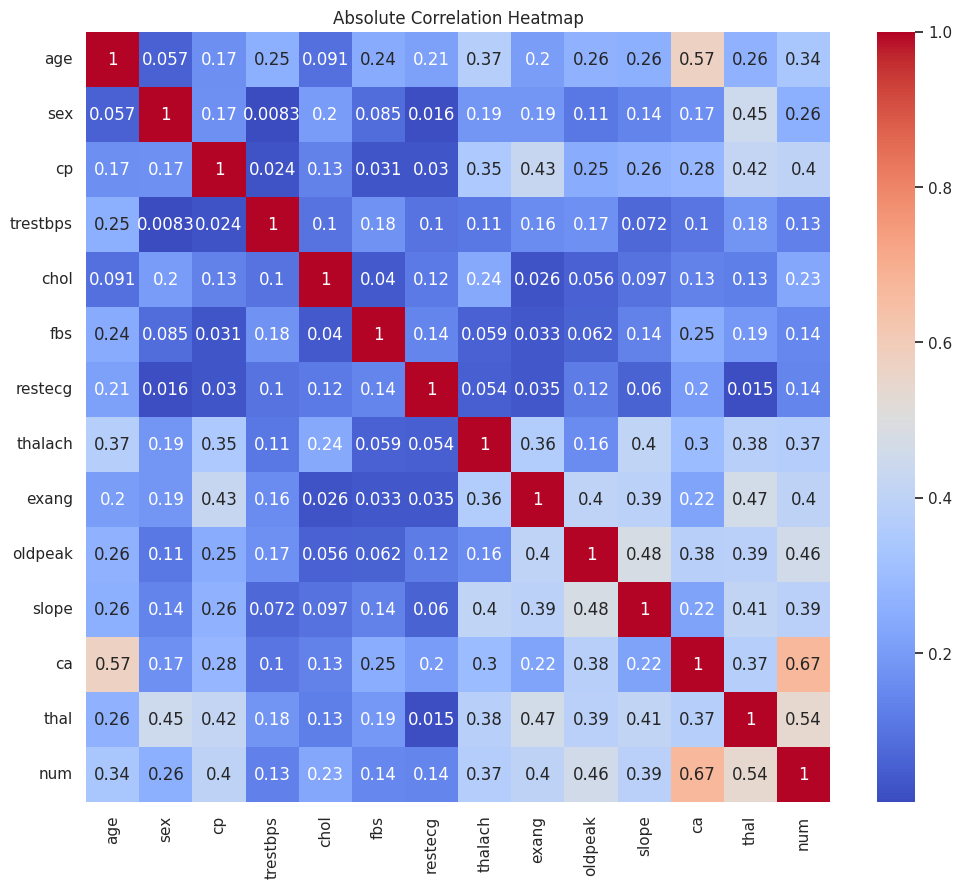

In [38]:
plt.figure(figsize=(12, 10))
sns.heatmap(heart_data_standardized.corr().abs(), annot=True, cmap="coolwarm", cbar=True)
plt.title("Absolute Correlation Heatmap")
plt.show()


<ipython-input-39-e2f28ac59226>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_classification, palette="Set2")


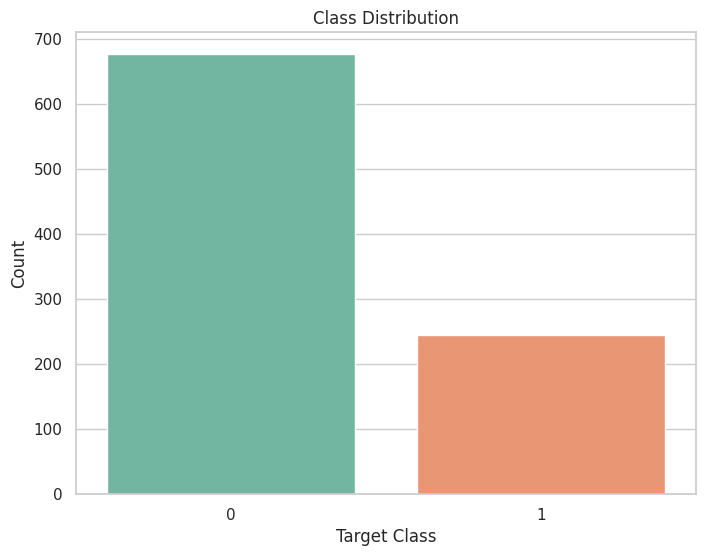

In [39]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y_classification, palette="Set2")
plt.title("Class Distribution")
plt.xlabel("Target Class")
plt.ylabel("Count")
plt.show()


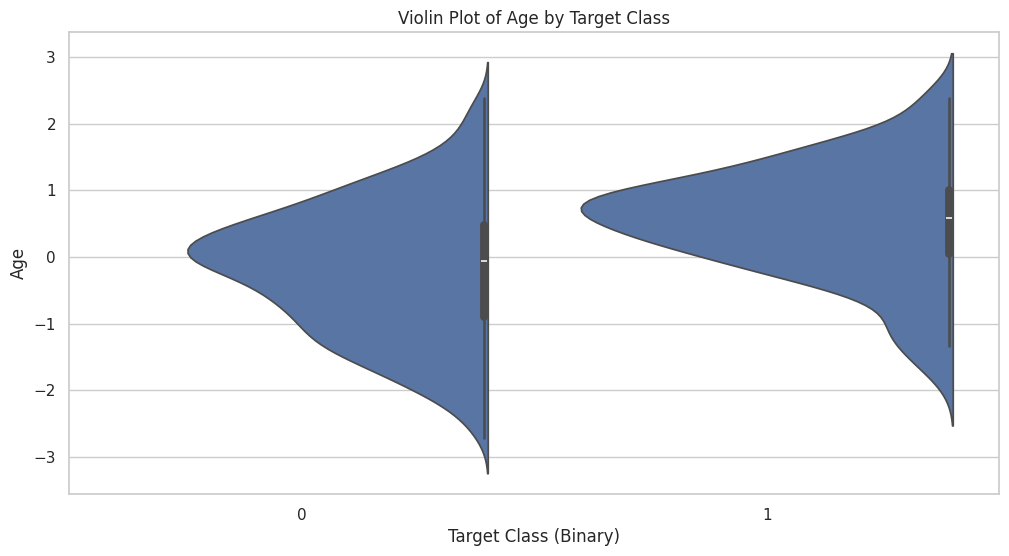

In [40]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=heart_data_standardized, x=y_classification, y='age', split=True)
plt.title("Violin Plot of Age by Target Class")
plt.xlabel("Target Class (Binary)")
plt.ylabel("Age")
plt.show()


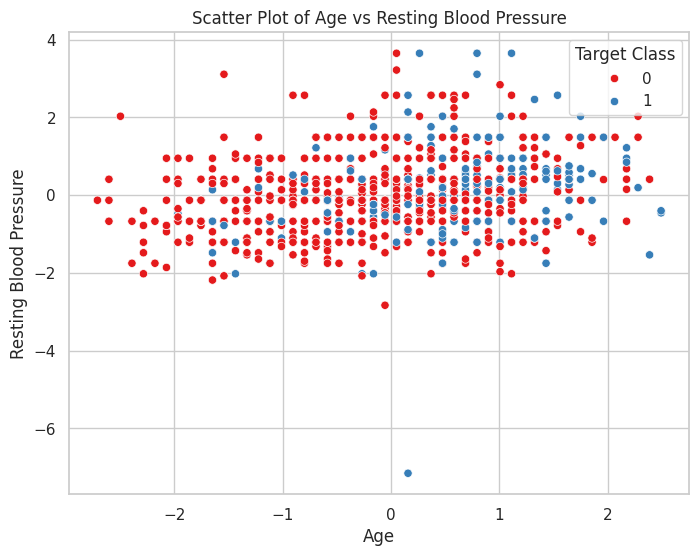

In [41]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=heart_data_standardized, x='age', y='trestbps', hue=y_classification, palette='Set1')
plt.title("Scatter Plot of Age vs Resting Blood Pressure")
plt.xlabel("Age")
plt.ylabel("Resting Blood Pressure")
plt.legend(title="Target Class")
plt.show()


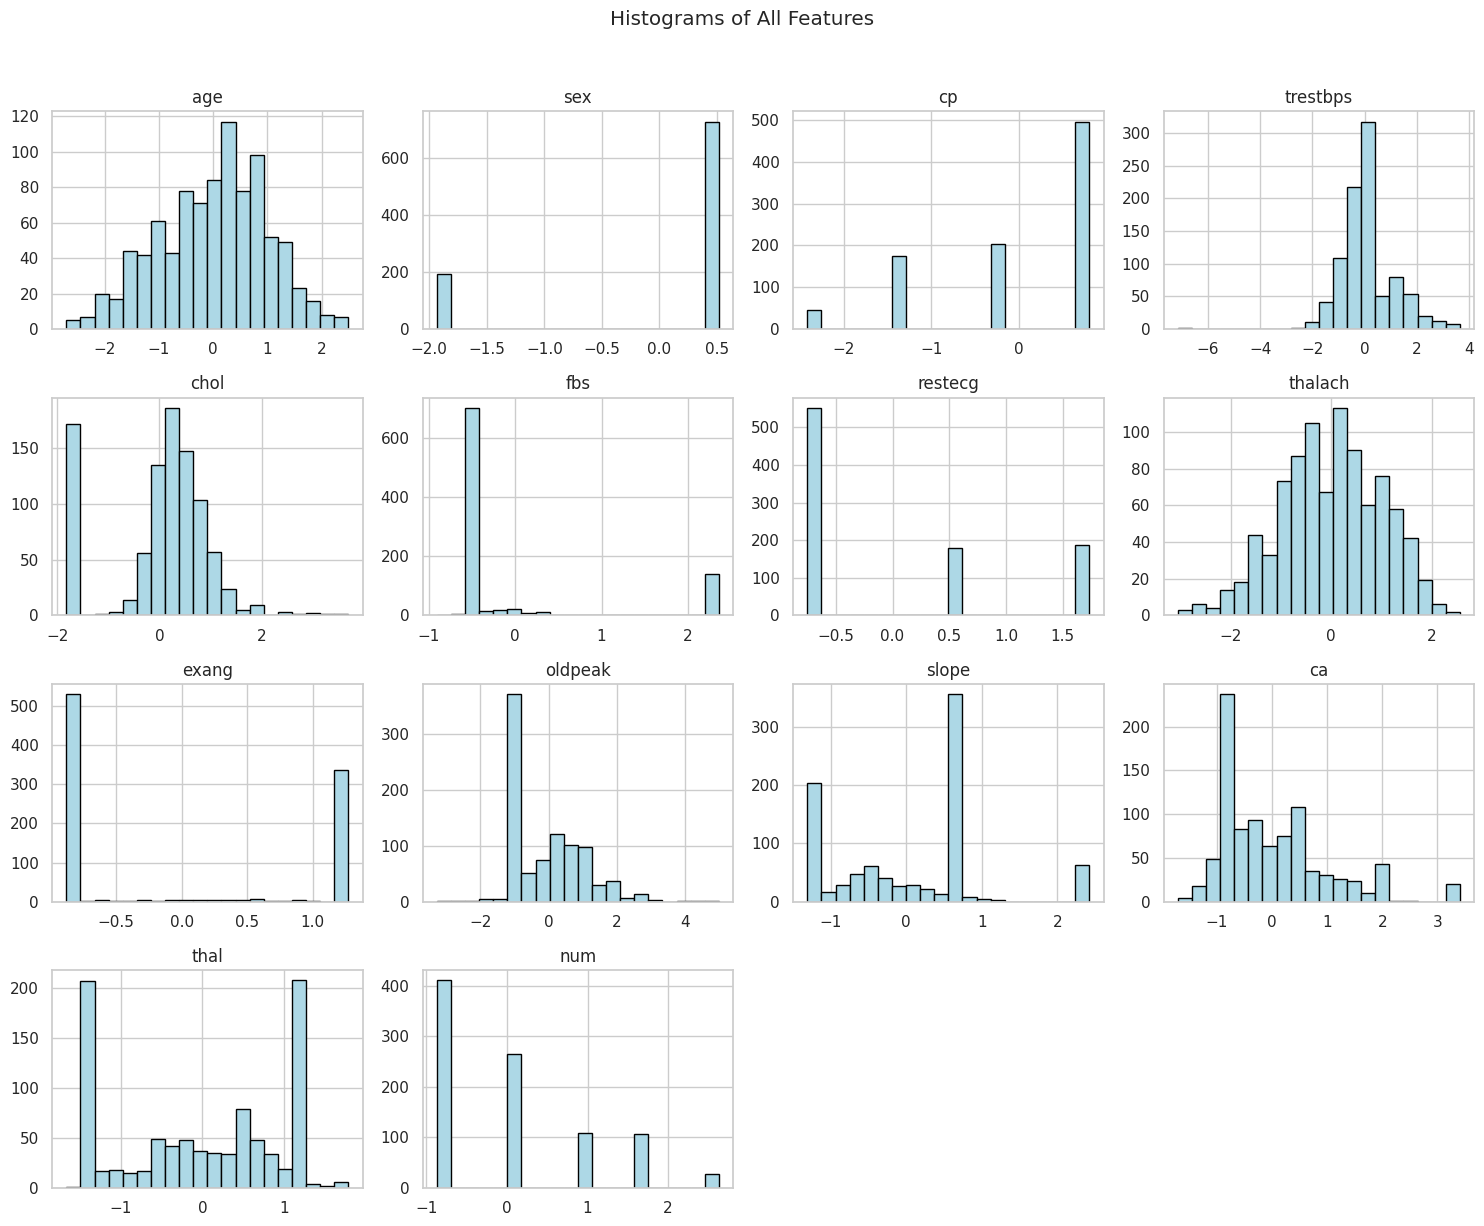

In [42]:
heart_data_standardized.hist(figsize=(15, 12), bins=20, color='lightblue', edgecolor='black')
plt.suptitle("Histograms of All Features", y=1.02)
plt.tight_layout()
plt.show()


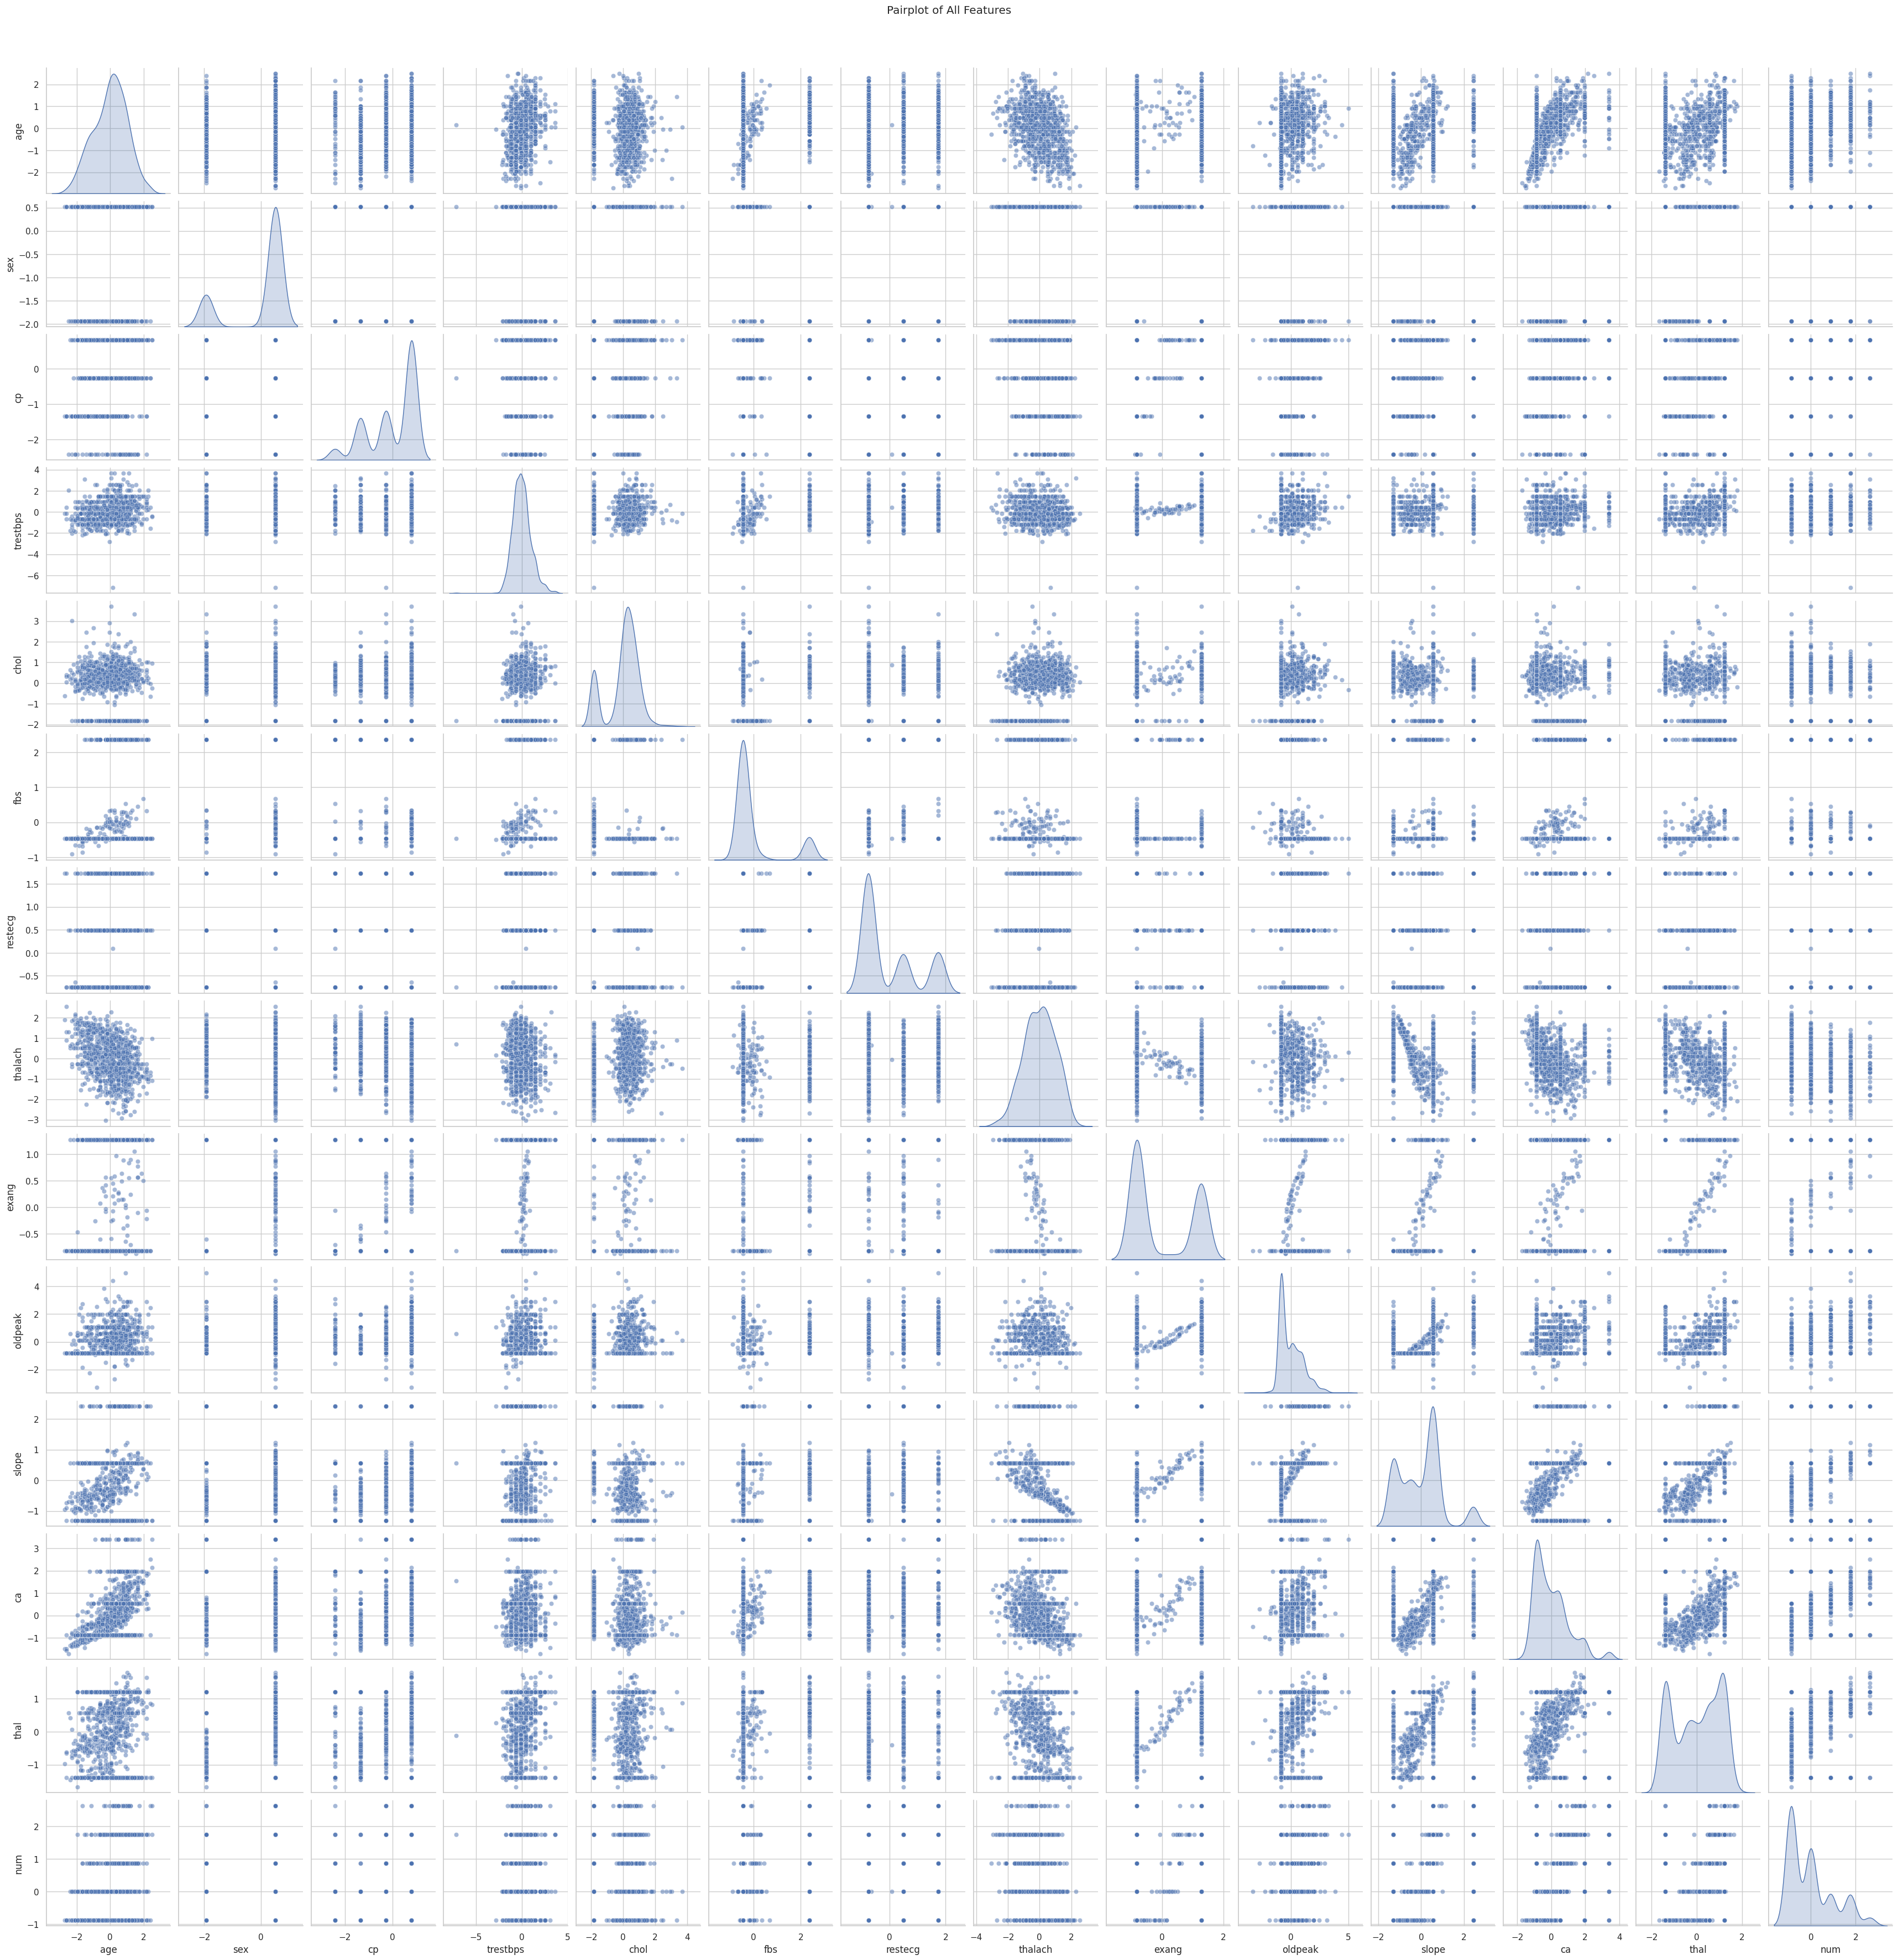

In [43]:
sns.pairplot(heart_data_standardized, diag_kind='kde', plot_kws={"alpha": 0.5})
plt.suptitle("Pairplot of All Features", y=1.02)
plt.show()


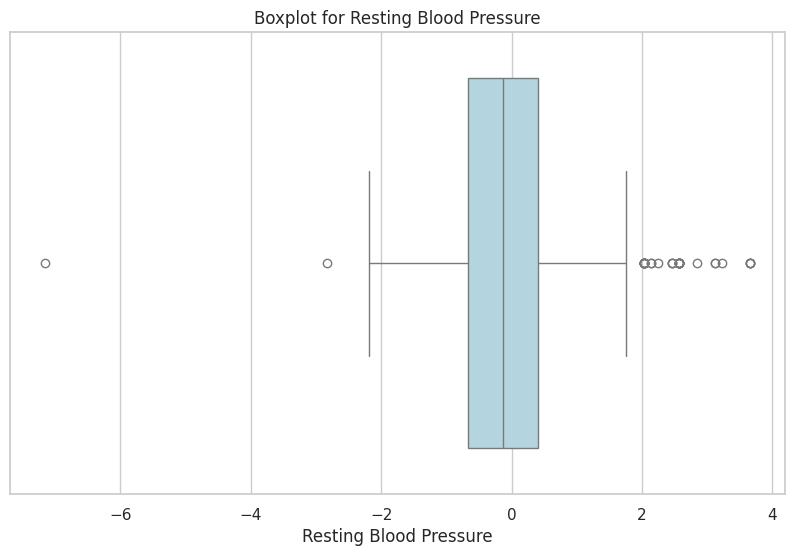

In [44]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=heart_data_standardized['trestbps'], color='lightblue')
plt.title("Boxplot for Resting Blood Pressure")
plt.xlabel("Resting Blood Pressure")
plt.show()
